# Spice Simulation of Sapflow Heater Control Circuit

Let's try to get it right before we get a PCB fabricated and loaded...

Spice simulation is standard electrical engineering stuff, see https://en.wikipedia.org/wiki/SPICE

We will do DC analysis and transient analysis to confirm this circuit has a chance of working.

## Requirements
In addition to Anaconda Python (https://www.continuum.io/anaconda) we need:
* the spice engine **ngspice** http://ngspice.sourceforge.net/
* Kicad http://kicad-pcb.org/ (or at least the hc.cir netlist we generate from the schematic we built in Kicad)


To build ngspice you need to enable xspice with the following:
`
cd release
../configure --with-x --with-readline=yes --disable-debug --enable-xspice
make
sudo make install
`
Note that there's a Python interface to the engine, **ngspyce** (https://github.com/ignamv/ngspyce), but I had difficulty getting the library it spoke with to run the xspice extensions.  So I gave up and just run ngspice from the command line.  It does the job.



In [1]:
# My standard setup for any Jupyter notebook
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

%reload_ext autoreload
%autoreload 2

In [2]:
# Most of the heavy lifting is done in our fix.py module 
import fix

# Load in our netlist from Kicad
ksf = fix.KicadSpiceFix('../hc.cir')

# Specify the include files we need for our simulation.  
# These are used for component models.
ksf.set_lines('include', [
    '.INCLUDE bc337.model',
    '.INCLUDE diodes.lib',
    '.INCLUDE LM358.101',
    '.INCLUDE tl431.lib',
    '.INCLUDE irfb7546pbf.spi'])


def set_target(target_v):
    """Adjust the pot for a given load voltage.
    
    We aim for target_v volts across our load terminals.
    Adjust the position of the potentiometer RV1 wiper to achieve this.
    
    The position is calculated by the gain of the diff stage 
    """
    # The gain of the voltage measuring stage is given by the ratio of its 
    # resistor pairs.
    diff_stage_gain = 33 / 100
    
    # The target value for the diff stage output is the target load voltage
    # scaled by the gain.
    target_v_diff = target_v * diff_stage_gain
    
    # The range of the pot output is 0V to 5V
    v_ref_max = 5
    
    # What percentage of the maximum reference voltage do we want?
    pos = target_v_diff / v_ref_max
    
    # Check it and set it.
    if pos < 0.0 or pos > 1.0:
        raise Exception("bad pot pos", pos, target_v)
    ksf.device('RV1').adjust(pos)
    

## DC (steady state) Analysis

Fix check that when the output is enabled, we provide the correct voltage to the load.

We will do a basic check for a $10\Omega$ load where we have dialed in a $10V$ load voltage.  (In which case we expect $I_{load} = 1A$ and $P_{load} = 10W$

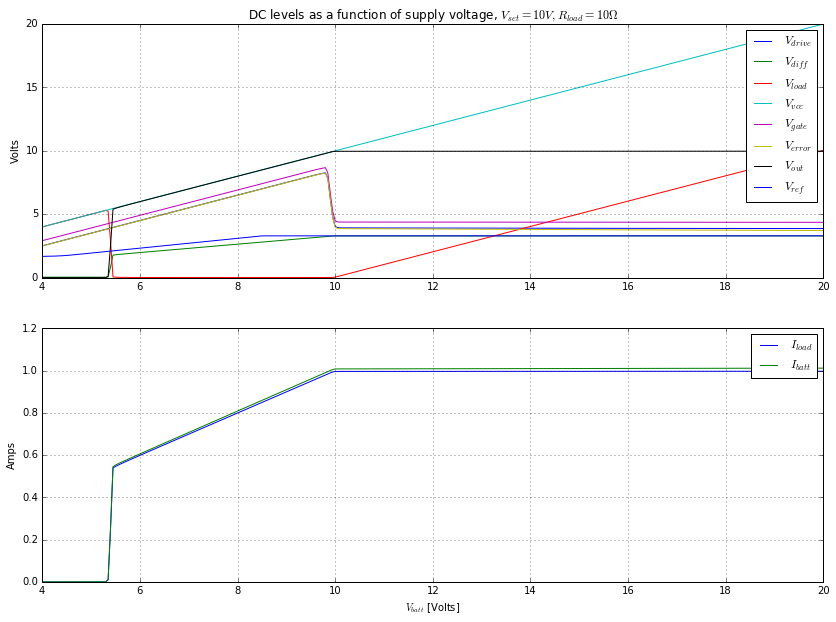

In [3]:
fix.delete_all_data_files()

node_str = "vcc gate diff load ref drive error i(vbatt) i(vload)"

Rload = 10
target_v = 10
set_target(target_v)

ksf.set_lines('load', [
    'Rload VCC l1 {}R'.format(Rload),
    'Lload l1 l2 3uH',
    'Vload l2 LOAD 0V',
    ])

ksf.set_lines('supplies', [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V'])

ksf.set_lines('control', [
    '.control',
    'dc Vbatt 4 20 0.05',
    'wrdata out1 ' + node_str,
    '.endc'])
 
ksf.write_and_run('t1.cir')

Vc, V, I = fix.read_wrdata_file('out1.data', node_str) 

I['batt'] = -I["batt"]
V['out'] = V["vcc"] - V['load']

title = "DC levels as a function of supply voltage, $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
fix.plot_all(
    Vc, V, I,
    title=title,
    xlabel="$V_{batt}$ [Volts]")


As expected, above battery voltages of 10V the circuit acts as a linear regulator, holding the load voltage at 10V.  There's 6mV of variation over the range of conceivable battery voltages.

140 241


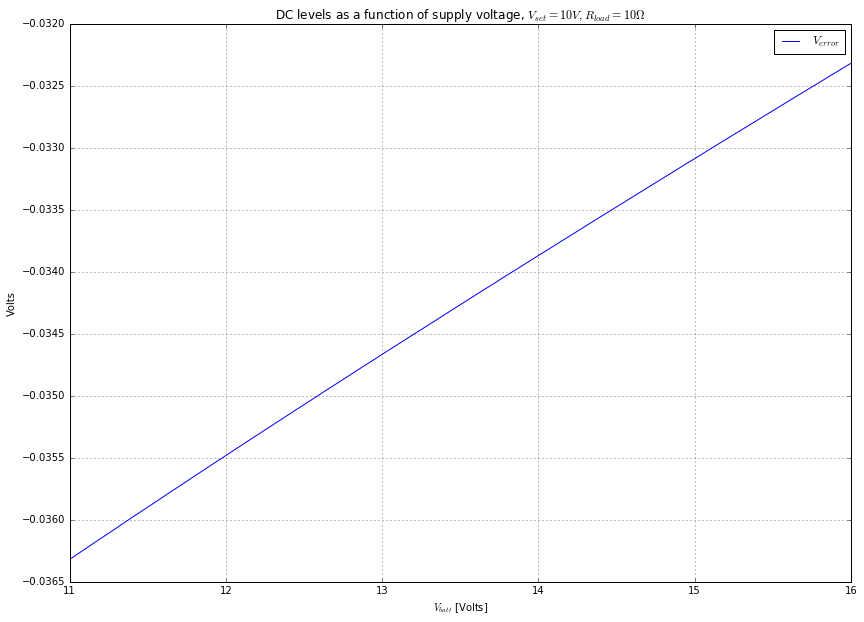

In [4]:
Verror = {"error": V["out"] - 10}
fix.plot_all(
    Vc, Verror, None,
    from_to=(11, 16),
    title=title,
    xlabel="$V_{batt}$ [Volts]")


Now let's check that the enable circuitry works.

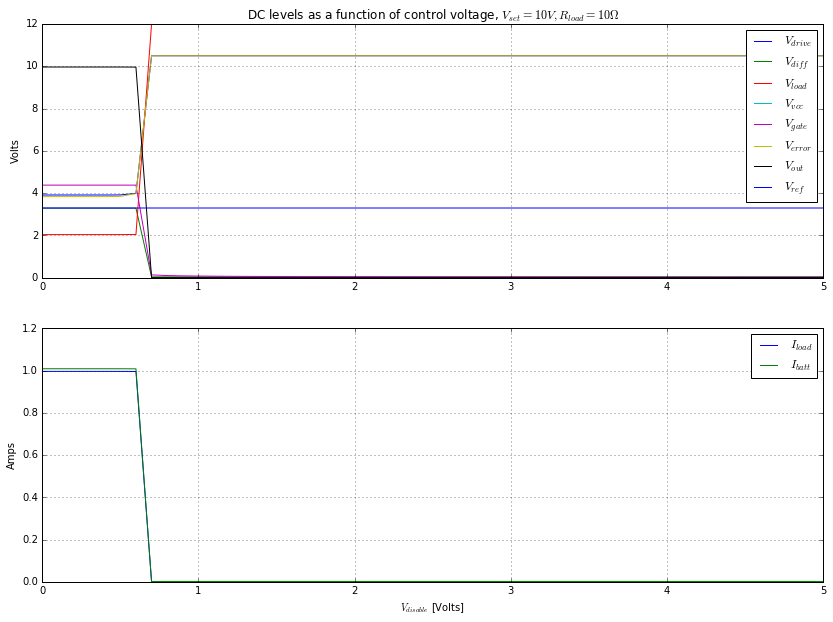

In [5]:
fix.delete_all_data_files()

node_str = "vcc gate diff load ref drive error i(vbatt) i(vload)"

Rload = 10
target_v = 10
set_target(target_v)

ksf.set_lines('control', [
    '.control',
    'dc Vdis 0 5 0.1',
    'wrdata out2 ' + node_str,
    '.endc'])

ksf.write_and_run('t2.cir')

Vc, V, I = fix.read_wrdata_file('out2.data', node_str)

V['out'] = V["vcc"] - V['load']
I['batt'] = -I["batt"]

title = "DC levels as a function of control voltage, $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
fix.plot_all(
    Vc, V, I,
    title=title,
    xlabel="$V_{disable}$ [Volts]")
  

As hoped, the transition occurs between 0.3 and 1.0V, so that will work fine with 3V3, 5V and 12V control lines (meaning we can use Arduino and CR1000 loggers).

## Transient (time domain) Analysis

* How smoothly do we transition between on and off states?
* How do we respond to changes in battery voltage?


In [6]:
def transient_analysis(duration, supplies, action):
    """Wrap up code for studying a given transition.
    
    * *Duration* gives how long the analysis runs.  10% of the time precedes the event, 90% follows.
    * *Supplies* is a list of strings specifying lines for SPICE.
    * *action* is a string that is included in the plot title.
    """
    fix.delete_all_data_files()
    node_str = "vcc gate diff load ref drive error i(vbatt) i(vload)"

    ksf.set_lines('control', [
        '.control',
        'tran 1us {}ms'.format(duration),
        'wrdata out_tran ' + node_str,
        '.endc'])

    pre = duration/10
    
    ksf.set_lines('supplies', [line.format(pre=pre) for line in supplies])

    ksf.write_and_run('trans.cir')

    t, V, I = fix.read_wrdata_file('out_tran.data', node_str)

    # convert to milliseconds and shift so that event occurs at 0ms
    t = t * 1000 - pre

    I['batt'] = -I["batt"]
    V['out'] = V["vcc"] - V['load']

    title = "Transient Analysis: " + action + ", $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
    xlabel='Time [mS]'
    fix.plot_all(
        t, V, I,
        title=title,
        xlabel=xlabel)

### Turning on the heater output

The battery is connected, the output is enabled by dropping the disable input's voltage from 5V to 0V (in 1ns).
The load has got $3{\mu}H$ of inductance, this is the sort of value we'd expect for 10m of cable running to a heater element (conductor diameter: 2mm, separation between them: 1mm).


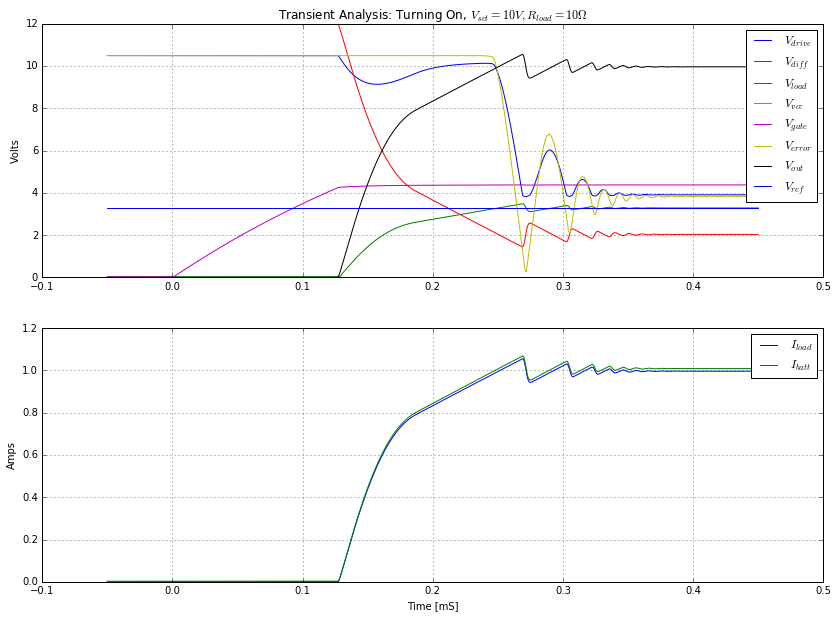

In [7]:
ksf.set_lines('load', [
    'Rload VCC l1 {}R'.format(Rload),
    'Lload l1 l2 3uH',
    'Vload l2 LOAD 0V',
    ])

supplies = [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V PULSE(5V 0V {pre}ms 1ns)']
transient_analysis(duration=0.5, supplies=supplies, action="Turning On")

In this simulation the output voltage, $V_{out}$, transitions from 0V to 10V in $250{\mu}S$ and settles down in $400{\mu}S$  Damping the oscillations is a reasonably big design challenge.  

### Turning off the heater output

The circuit is providing current to the heater element.  We stop this by pulling the disable line high (taking 1ns to do it).


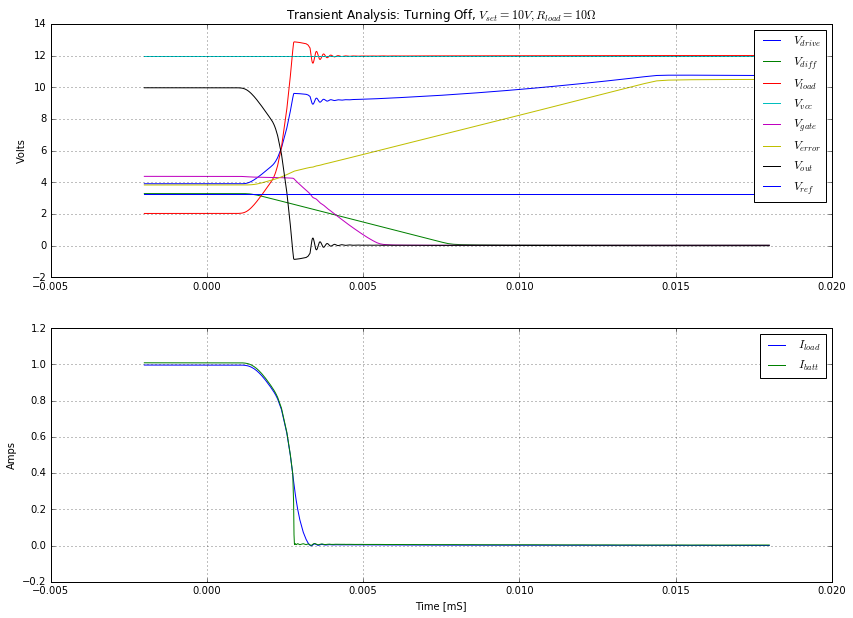

In [8]:
supplies = [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V PULSE(0V 5V {pre}ms 1ns)']
transient_analysis(0.02, supplies, "Turning Off")

The current turns off nice and fast.  Note that the voltage across the load goes negative for about $1{\mu}S$ - this is due to the inductance in the cable to the heaters.  The protection diode, D1, clamps this back EMF at about 1V, stopping any damage to the circuit.

### Battery Voltage Rise

Here we simulate the 12V battery jumping by 1V in 1ms.  The output stays steady, betraying only a slight wobble (of 0.1%) as the rate of change switched from 0V/mS to 10V/ms and back again.

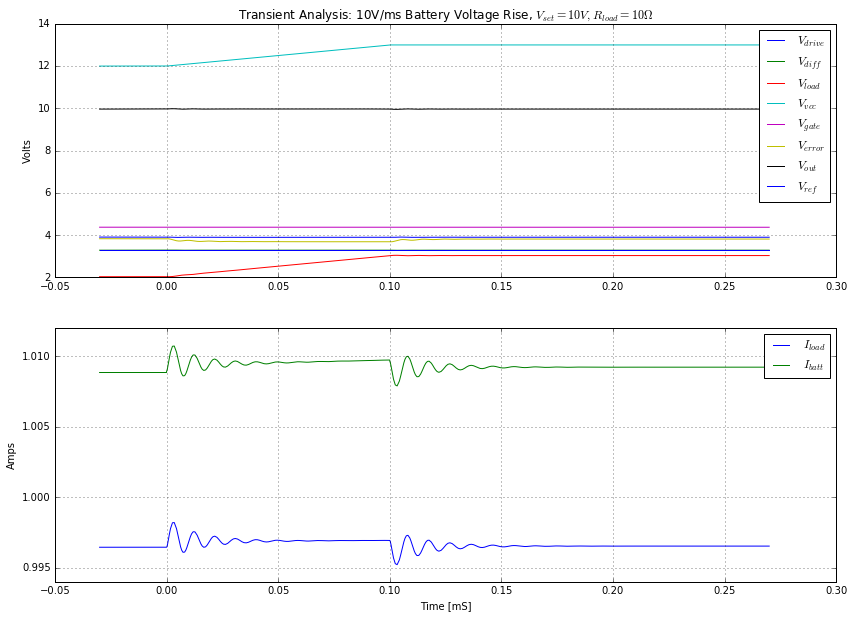

In [9]:
supplies = [
    'Vbatt VCC GND 12V  PULSE(12V 13V {pre}ms 100us)',
    'Vdis disable GND 0V']
transient_analysis(duration=0.3, supplies=supplies, action="10V/ms Battery Voltage Rise")

### Battery Voltage Fall

As before but we simulate a 1V fall over 1ms.  The impact is as before, wobbles at the start and end of the ramp.


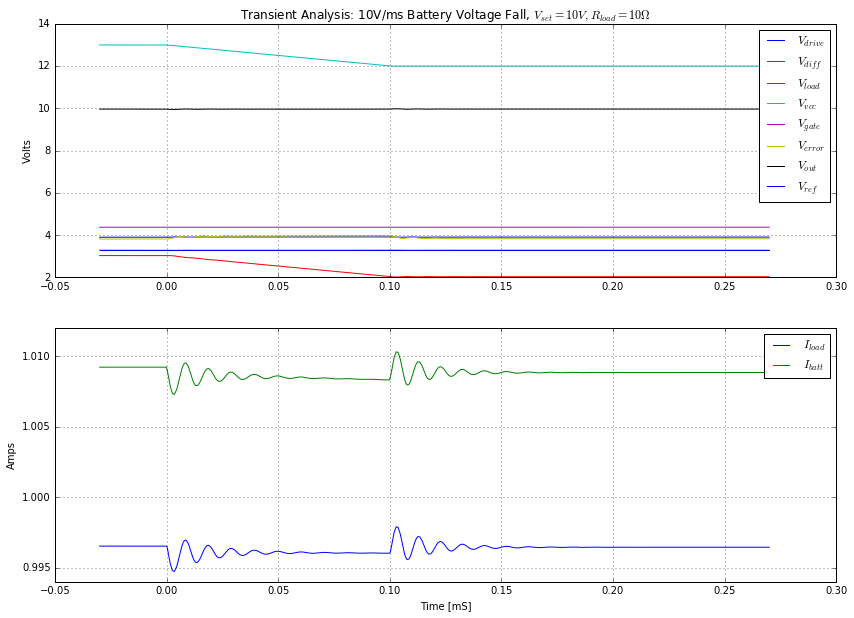

In [10]:
supplies = [
    'Vbatt VCC GND 12V  PULSE(13V 12V {pre}ms 100us)',
    'Vdis disable GND 0V']
transient_analysis(duration=0.3, supplies=supplies, action="10V/ms Battery Voltage Fall")

# Trying different MOSFETs

Requirements
* TO220 package
* max Vgs >= 20V (or we have to use a zener between gate and ground)
* Vdss breakdown > 30V
* Id > 5A (or so)
* Vgs(threshold) < 5V or so
* Rds(on) < 100mR (smaller is better)
* cheap (< $1) and available

http://www.infineon.com/cms/en/product/solutionFinder.html?channel=db3a30433cabdd35013ccebb4e4849ae&intc=0540001#!showAllParameters=false&5546d4694909da48014909dc05ad019b_false=5&5546d4694909da48014909dc0d0d0207_false=20&5546d4694909da48014909dc15af0281_false=1&sort=group&sortField=SMALLEST&5546d4694909da48014909dc081301b1_true=MAX_30.0|MAX_40.0|MAX_55.0|MAX_60.0&5546d4694909da48014909dc13370259_true=N&packageValue=TO220&statusValue=active%20and%20preferred

Candidates (there are plenty):
* IRF40B207 http://www.mouser.com/ProductDetail/Infineon-Technologies/IRF40B207
* IRFB7446 http://www.mouser.com/ProductDetail/Infineon/IRFB7446PB
* IRFB7546 http://www.mouser.com/ProductDetail/Infineon-Technologies/IRFB7546PBF
* PSMN022-30PL http://www.mouser.com/ProductDetail/Nexperia/PSMN022-30PL127
* IRLB8721 http://www.mouser.com/ProductDetail/Infineon-Technologies/IRLB8721PBF

In [16]:

node_str = "vcc load i(vbatt) i(vload)"

ksf.set_lines('supplies', [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V'])

ksf.set_lines('control', [
    '.control',
    'dc Vbatt 11 16 0.05',
    'wrdata out1 ' + node_str,
    '.endc'])

def sweep_target_v():

    Vout = {}

    for target_v in range(6, 16):
        fix.delete_all_data_files()

        set_target(target_v)

        ksf.write_and_run('t1.cir')

        Vc, Vt, I = fix.read_wrdata_file('out1.data', node_str) 

        Vout["tar = {}V".format(target_v)] = Vt["vcc"] - Vt['load']

    title = "Load Voltage as a function of supply voltage for different set voltage, $R_{load}="+str(Rload)+"\Omega$"
    fix.plot_all(
        Vc, Vout, None,
        title=title,
        xlabel="$V_{batt}$ [Volts]")
    plt.plot(Vc, Vc, ':k')

##########STDOUT##########

Circuit: * ../hc.cir

Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 101

##########STDERR##########
Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   3.1623E-07 Note: One successful gmin step
Trying gmin =   5.6234E-08 Note: One successful gmin step
Trying gmin =   5.6234E-09 Note: One successful gmin step
Trying gmin =   5.6234E-10 Note: One successful gmin step
Trying gmin =   5.6234E-11 Note: One successful gmin step
Trying gmin =   5.6234E-12 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Note: Dynamic gmin stepping completed

Note: No ".plot", ".print", or ".fourier" lines; no simulations run

##########STDOU

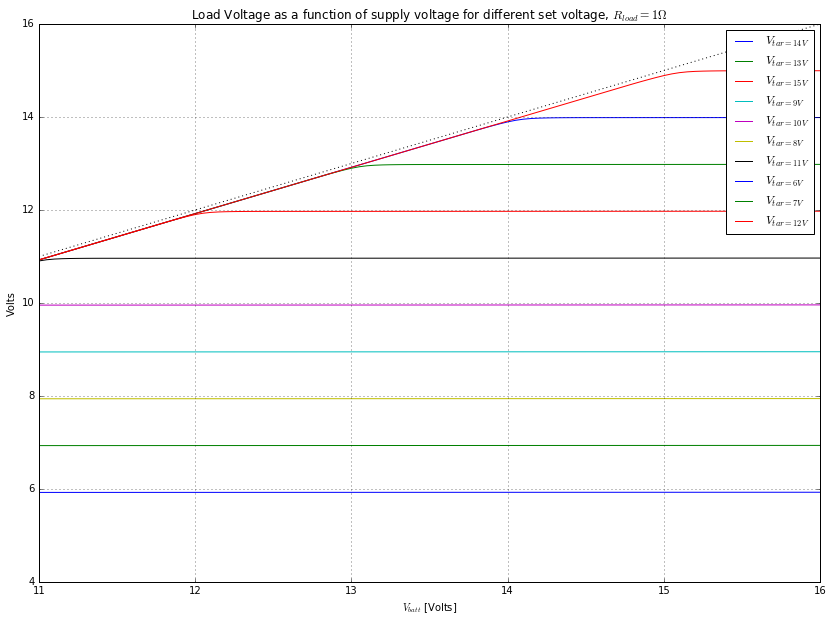

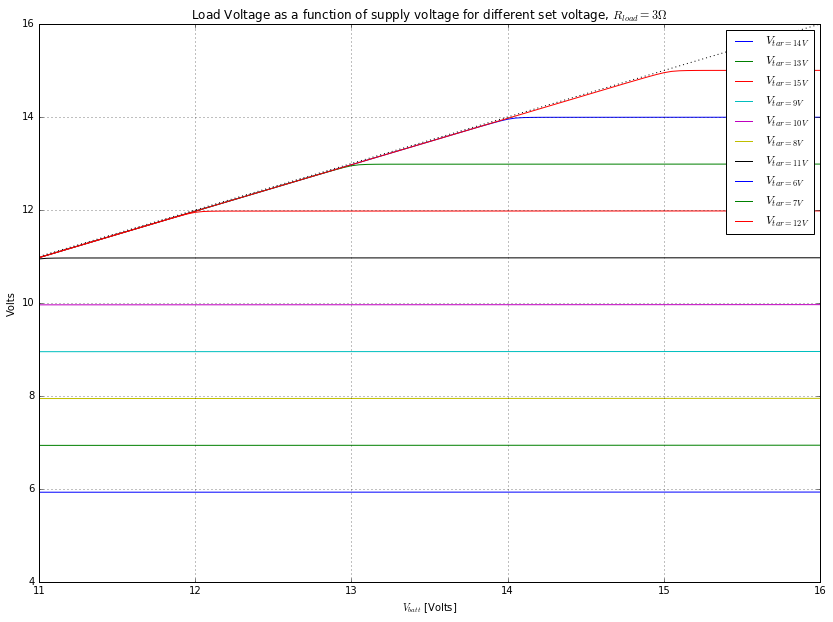

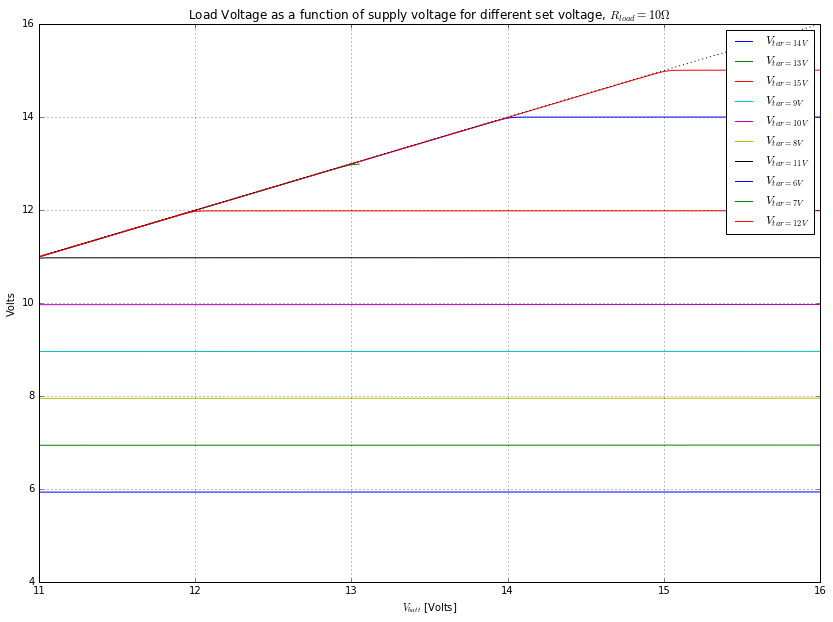

In [17]:
for r in [1, 3, 10]:
    Rload = r
    ksf.set_lines('load', [
        'Rload VCC l1 {}R'.format(Rload),
        'Lload l1 l2 3uH',
        'Vload l2 LOAD 0V',
        ])

    sweep_target_v()